<center><h1 class="list-group-item list-group-item-success">Stroke Prediction</center>
<img src = "https://topnews.in/healthcare/sites/default/files/styles/large/public/Stroke7.jpg?itok=xInaWFYK">
    
### Context
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

In [1]:
!pip install pycaret

The system cannot find the path specified.


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from imblearn.over_sampling import SMOTE
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,mean_squared_error,mean_absolute_error,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler,normalize
import pickle

In [72]:
df = pd.read_csv("../Data/stroke.csv")

In [75]:
df_copy =  df.copy()

In [76]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [77]:
df.corr()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.000000,0.003538,0.003550,-0.001296,0.001092,0.003084,0.006388
age,0.003538,1.000000,0.276398,0.263796,0.238171,0.333398,0.245257
hypertension,0.003550,0.276398,1.000000,0.108306,0.174474,0.167811,0.127904
heart_disease,-0.001296,0.263796,0.108306,1.000000,0.161857,0.041357,0.134914
avg_glucose_level,0.001092,0.238171,0.174474,0.161857,1.000000,0.175502,0.131945
bmi,0.003084,0.333398,0.167811,0.041357,0.175502,1.000000,0.042374
stroke,0.006388,0.245257,0.127904,0.134914,0.131945,0.042374,1.000000


In [78]:
px.histogram(df,x='work_type',color='work_type',template='plotly_dark')

In [79]:
px.histogram(df,x='smoking_status',color='smoking_status',template='plotly_dark')

In [80]:
df["stroke"].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

<BarContainer object of 5110 artists>

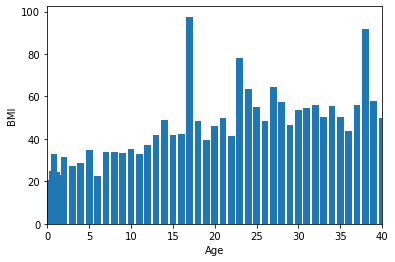

In [81]:
plt.xlabel("Age")
plt.ylabel("BMI")
plt.xlim(0,40)
plt.bar(df["age"],df["bmi"])

<BarContainer object of 5110 artists>

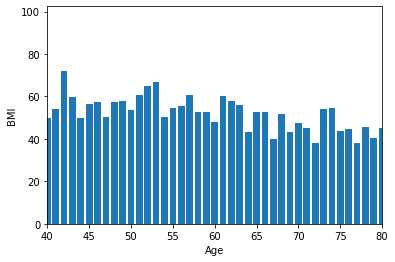

In [83]:
plt.xlabel("Age")
plt.ylabel("BMI")
plt.xlim(40,80)
plt.bar(df["age"],df["bmi"])

In [84]:
df.dropna(inplace=True)

In [85]:
df = df.reset_index(drop = True)

In [86]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4904,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
4905,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
4906,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
4907,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [87]:
gender = pd.get_dummies(df["gender"])
ever_married = pd.get_dummies(df["ever_married"])
work_type = pd.get_dummies(df["work_type"])
residence_type = pd.get_dummies(df["Residence_type"])
smoking_status = pd.get_dummies(df["smoking_status"])
df["Male"] = gender["Male"]
df["Female"] = gender["Female"]
df["Other"] = gender["Other"]
df["Govt_Job"] = work_type["Govt_job"]
df["Never_Worked"] = work_type["Never_worked"]
df["Private"] = work_type["Private"]
df["Self-Employed"] = work_type["Self-employed"]
df["children"] = work_type["children"]
df["ever_married"]=ever_married["Yes"]
df["Urban"]=residence_type["Urban"]
df["Rural"]=residence_type["Rural"]
df["Unknown"] = smoking_status["Unknown"]
df["Formerly_Smoked"] = smoking_status["formerly smoked"]
df["Never_Smoked"] = smoking_status["never smoked"]
df["Smokes"] = smoking_status["smokes"]

In [88]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,Never_Worked,Private,Self-Employed,children,Urban,Rural,Unknown,Formerly_Smoked,Never_Smoked,Smokes
0,9046,Male,67.0,0,1,1,Private,Urban,228.69,36.6,...,0,1,0,0,1,0,0,1,0,0
1,31112,Male,80.0,0,1,1,Private,Rural,105.92,32.5,...,0,1,0,0,0,1,0,0,1,0
2,60182,Female,49.0,0,0,1,Private,Urban,171.23,34.4,...,0,1,0,0,1,0,0,0,0,1
3,1665,Female,79.0,1,0,1,Self-employed,Rural,174.12,24.0,...,0,0,1,0,0,1,0,0,1,0
4,56669,Male,81.0,0,0,1,Private,Urban,186.21,29.0,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,14180,Female,13.0,0,0,0,children,Rural,103.08,18.6,...,0,0,0,1,0,1,1,0,0,0
4905,44873,Female,81.0,0,0,1,Self-employed,Urban,125.20,40.0,...,0,0,1,0,1,0,0,0,1,0
4906,19723,Female,35.0,0,0,1,Self-employed,Rural,82.99,30.6,...,0,0,1,0,0,1,0,0,1,0
4907,37544,Male,51.0,0,0,1,Private,Rural,166.29,25.6,...,0,1,0,0,0,1,0,1,0,0


In [89]:
columns_to_drop = ["id","work_type","smoking_status","Residence_type","gender"]
df.drop(columns_to_drop,axis = 1,inplace= True)

In [90]:
df.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi', 'stroke', 'Male', 'Female', 'Other',
       'Govt_Job', 'Never_Worked', 'Private', 'Self-Employed', 'children',
       'Urban', 'Rural', 'Unknown', 'Formerly_Smoked', 'Never_Smoked',
       'Smokes'],
      dtype='object')

In [91]:
X = df.drop("stroke",axis = 1)
Y = df["stroke"]

In [92]:
X

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,Male,Female,Other,Govt_Job,Never_Worked,Private,Self-Employed,children,Urban,Rural,Unknown,Formerly_Smoked,Never_Smoked,Smokes
0,67.0,0,1,1,228.69,36.6,1,0,0,0,0,1,0,0,1,0,0,1,0,0
1,80.0,0,1,1,105.92,32.5,1,0,0,0,0,1,0,0,0,1,0,0,1,0
2,49.0,0,0,1,171.23,34.4,0,1,0,0,0,1,0,0,1,0,0,0,0,1
3,79.0,1,0,1,174.12,24.0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,81.0,0,0,1,186.21,29.0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,13.0,0,0,0,103.08,18.6,0,1,0,0,0,0,0,1,0,1,1,0,0,0
4905,81.0,0,0,1,125.20,40.0,0,1,0,0,0,0,1,0,1,0,0,0,1,0
4906,35.0,0,0,1,82.99,30.6,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4907,51.0,0,0,1,166.29,25.6,1,0,0,0,0,1,0,0,0,1,0,1,0,0


In [96]:
li = []
for i in X.iloc[4904]:
    li.append(i)
li

[13.0,
 0.0,
 0.0,
 0.0,
 103.08,
 18.6,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0]

In [20]:
sm = SMOTE(random_state=27,k_neighbors=10)
X, Y = sm.fit_resample(X,Y)

In [21]:
Y.value_counts()

0    4700
1    4700
Name: stroke, dtype: int64

In [22]:
df_final = pd.concat([X,Y],axis = 1)

In [23]:
train,test = train_test_split(df_final, test_size=0.25,random_state= 27)

In [24]:
experiment = setup(
    data = train,
    target = 'stroke',
    normalize = True
)

,Description,Value
0,session_id,7658
1,Target,stroke
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(7050, 21)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [25]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9730,0.9947,0.9621,0.9840,0.9729,0.9461,0.9464,0.1170
rf,Random Forest Classifier,0.9722,0.9961,0.9609,0.9836,0.9720,0.9445,0.9448,0.1620
catboost,CatBoost Classifier,0.9712,0.9944,0.9576,0.9847,0.9709,0.9424,0.9429,8.1230
lightgbm,Light Gradient Boosting Machine,0.9710,0.9940,0.9564,0.9855,0.9707,0.9420,0.9426,1.1550
gbc,Gradient Boosting Classifier,0.9637,0.9907,0.9427,0.9844,0.9631,0.9275,0.9284,0.1870
lr,Logistic Regression,0.9619,0.9884,0.9302,0.9936,0.9608,0.9238,0.9258,0.7090
svm,SVM - Linear Kernel,0.9613,0.0000,0.9234,0.9996,0.9599,0.9226,0.9254,0.0150
ada,Ada Boost Classifier,0.9605,0.9882,0.9322,0.9885,0.9595,0.9210,0.9225,0.0740
knn,K Neighbors Classifier,0.9520,0.9866,0.9637,0.9422,0.9527,0.9039,0.9043,0.4230
ridge,Ridge Classifier,0.9451,0.0000,0.8915,0.9991,0.9422,0.8902,0.8955,0.0100


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=7658, verbose=0,
                     warm_start=False)

In [115]:
X = normalize(X)

In [116]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.25, random_state = 42)

In [127]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', X_test.shape)
print('Testing Features Shape:', Y_train.shape)
print('Testing Labels Shape:', Y_test.shape)

Training Features Shape: (3681, 20)
Training Labels Shape: (1228, 20)
Testing Features Shape: (3681,)
Testing Labels Shape: (1228,)


In [128]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

In [129]:
rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [130]:
Y_pred = rf.predict(X_test)

In [131]:
print(accuracy_score(Y_pred,Y_test))

0.9486970684039088


In [132]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 150, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5,8,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 24, 38, 52, 66, 80, 94, 108, 122, 136, 150, None], 'min_samples_split': [2, 5, 8, 10], 'min_samples_leaf': [1, 2, 4, 8], 'bootstrap': [True, False]}


In [133]:
rf1 = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, n_iter = 25, cv = 2, verbose=2, random_state=42, n_jobs = -1)

In [134]:
rf_random.fit(X_train, Y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.9s finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [135]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 150,
 'bootstrap': False}

In [136]:
predictions = rf_random.predict(X_test)

In [137]:
print(accuracy_score(predictions,Y_test))

0.9478827361563518


In [139]:
pickle.dump(rf_random,open("../models/model_stroke.pkl","wb"))

In [40]:
array = [[44,0,0,1,85.28,26.2,0,1,0,1,0,0,0,0,1,0,1,0,0,0]]

In [47]:
a = MinMaxScaler().fit_transform(array)

In [48]:
rf_random.predict(a)

array([1], dtype=int64)

In [61]:
l  =['age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi','Male', 'Female', 'Other',
       'Govt_Job', 'Never_Worked', 'Private', 'Self-Employed', 'children',
       'Urban', 'Rural', 'Unknown', 'Formerly_Smoked', 'Never_Smoked',
       'Smokes']

In [62]:
d = pd.DataFrame(X_train,columns= l)

In [68]:
list = []
for i in d.iloc[7048]:
    list.append(i)

In [69]:
list

[0.76806640625,
 0.0,
 0.0,
 1.0,
 0.012464223063429092,
 0.21191294387170678,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0]

In [70]:
rf_random.predict(np.array(list).reshape(1,-1))

array([0], dtype=int64)

In [66]:
d

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,Male,Female,Other,Govt_Job,Never_Worked,Private,Self-Employed,children,Urban,Rural,Unknown,Formerly_Smoked,Never_Smoked,Smokes
0,0.655811,0.0,0.0,1.0,0.066480,0.212517,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.525158,0.0,0.0,1.0,0.032800,0.254316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.790213,0.0,0.0,1.0,0.792742,0.214580,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.267578,0.0,0.0,0.0,0.309205,0.152348,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.841309,0.0,1.0,1.0,0.746838,0.223368,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7045,0.728116,0.0,0.0,1.0,0.260162,0.271061,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7046,0.910855,1.0,0.0,1.0,0.070491,0.197873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7047,0.954817,0.0,0.0,0.0,0.021316,0.161045,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7048,0.768066,0.0,0.0,1.0,0.012464,0.211913,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [67]:
Y_train

7728    1
6711    1
7436    1
468     0
1545    0
       ..
5734    1
5191    1
5390    1
860     0
7270    1
Name: stroke, Length: 7050, dtype: int64

In [123]:
a = np.array(li).reshape(1,-1)

In [124]:
a

array([[ 13.  ,   0.  ,   0.  ,   0.  , 103.08,  18.6 ,   0.  ,   1.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   1.  ,
          1.  ,   0.  ,   0.  ,   0.  ]])

In [125]:
b = normalize(a)

In [126]:
b

array([[0.12314424, 0.        , 0.        , 0.        , 0.9764391 ,
        0.17619099, 0.        , 0.00947263, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00947263, 0.        ,
        0.00947263, 0.00947263, 0.        , 0.        , 0.        ]])